# Portfolio Analysis Dashboard

포트폴리오 분석 및 시각화

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from datetime import date, datetime, timedelta
import sys
sys.path.insert(0, '..')

from config.settings import Settings

settings = Settings()

# DB 연결 (터널링 시 포트 변경 필요)
DB_HOST = "127.0.0.1"
DB_PORT = 3307  # 터널링 시 변경 (예: 3307)

engine = create_engine(
    f"mysql+pymysql://{settings.DB_USER}:{settings.DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{settings.DB_NAME}?charset=utf8mb4"
)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print(f"Connected to {settings.DB_NAME}")

Connected to asset


In [18]:
# 유틸리티 함수: 가장 최근 거래일 찾기
def get_latest_trading_date(engine, target_date=None):
    """주어진 날짜 이하의 가장 최근 거래일 반환"""
    if target_date is None:
        target_date = date.today()
    
    sql = """
    SELECT MAX(snapshot_date) AS latest_date
    FROM daily_portfolio_snapshot
    WHERE snapshot_date <= :target_date
    """
    result = pd.read_sql(text(sql), engine, params={"target_date": target_date})
    return result.loc[0, 'latest_date']

# 가장 최근 거래일
LATEST_TRADING_DATE = get_latest_trading_date(engine)
print(f"가장 최근 거래일: {LATEST_TRADING_DATE}")

가장 최근 거래일: 2026-02-27


---
## 1. 오늘 매도한 종목 (실현수익률, 보유기간)

In [19]:
# 매도일 선택 (기본: 가장 최근 거래일)
SELL_DATE = LATEST_TRADING_DATE  # 또는 date(2026, 1, 30)

# 매도 내역 + Kiwoom 이동평균 기준 수익률
sql_sold = """
WITH sell_summary AS (
    SELECT
        stk_cd,
        stk_nm,
        AVG(cntr_uv) AS avg_sell_price,
        SUM(cntr_qty) AS total_sell_qty,
        SUM(cntr_uv * cntr_qty) AS total_sell_amt
    FROM account_trade_history
    WHERE trade_date = :sell_date
      AND (io_tp_nm LIKE '%매도%' OR io_tp_nm LIKE '%상환%')
    GROUP BY stk_cd, stk_nm
),
holding_info AS (
    -- 전일 보유 종목의 매수평균가 (Kiwoom 이동평균)
    SELECT
        stk_cd,
        AVG(avg_prc) AS avg_buy_price,
        DATEDIFF(:sell_date, MIN(snapshot_date)) AS holding_days
    FROM holdings
    WHERE snapshot_date = (
        SELECT MAX(snapshot_date) FROM holdings WHERE snapshot_date < :sell_date
    )
    GROUP BY stk_cd
),
holding_today AS (
    -- 매도 당일에도 일부 보유 중인 경우
    SELECT
        stk_cd,
        AVG(avg_prc) AS avg_buy_price
    FROM holdings
    WHERE snapshot_date = :sell_date
    GROUP BY stk_cd
),
same_day_buy_info AS (
    -- 순수 당일매매 fallback (holdings에 없는 경우)
    SELECT
        stk_cd,
        AVG(cntr_uv) AS avg_buy_price,
        0 AS holding_days
    FROM account_trade_history
    WHERE trade_date = :sell_date
      AND io_tp_nm LIKE '%매수%'
    GROUP BY stk_cd
)
SELECT
    REPLACE(s.stk_nm, '*', '') AS 종목명,
    -- 우선순위: 전일holdings(Kiwoom 이동평균) > 당일holdings > 당일매수(day-trade fallback)
    CAST(COALESCE(h.avg_buy_price, ht.avg_buy_price, sd.avg_buy_price) AS SIGNED) AS 매수평균가,
    CAST(s.avg_sell_price AS SIGNED) AS 매도평균가,
    ROUND((s.avg_sell_price - COALESCE(h.avg_buy_price, ht.avg_buy_price, sd.avg_buy_price))
          / COALESCE(h.avg_buy_price, ht.avg_buy_price, sd.avg_buy_price) * 100, 2) AS 수익률,
    CASE WHEN ht.stk_cd IS NOT NULL THEN 'Y' ELSE 'N' END AS 현재보유여부,
    COALESCE(h.holding_days, sd.holding_days) AS 홀딩기간
FROM sell_summary s
LEFT JOIN holding_info h ON s.stk_cd = h.stk_cd
LEFT JOIN holding_today ht ON s.stk_cd = ht.stk_cd
LEFT JOIN same_day_buy_info sd ON s.stk_cd = sd.stk_cd
ORDER BY 수익률 DESC
"""

columns = ['종목명', '매수평균가', '매도평균가', '수익률', '현재보유여부', '홀딩기간']
df_sold = pd.read_sql(text(sql_sold), engine, params={"sell_date": SELL_DATE})

if len(df_sold) == 0:
    print(f"{SELL_DATE} 매도 종목: 0건")
    
    # 헤더는 유지하고 "매도 종목 없음" 표시
    from IPython.display import HTML
    header_html = '<table style="text-align:center; margin:auto; border-collapse:collapse;">'
    header_html += '<thead><tr>' + ''.join(
        f'<th style="padding:8px 16px; border-bottom:2px solid #ddd; font-weight:bold;">{c}</th>'
        for c in columns
    ) + '</tr></thead>'
    header_html += '<tbody><tr><td colspan="6" style="padding:20px; color:#888; font-size:14px;">매도 종목 없음</td></tr></tbody>'
    header_html += '</table>'
    display(HTML(header_html))

    # PNG용 styled DataFrame
    empty_df = pd.DataFrame({c: ['매도 종목 없음' if c == '종목명' else ''] for c in columns}, index=[0])
    df_styled = (
        empty_df.style
        .hide(axis='index')
        .set_properties(**{'text-align': 'center', 'color': '#888'})
    )
else:
    print(f"{SELL_DATE} 매도 종목: {len(df_sold)}건")
    
    # 홀딩기간 포맷: 숫자면 "X일", 없으면 "-"
    df_sold["홀딩기간"] = df_sold["홀딩기간"].apply(
        lambda x: f"{int(x)}일" if pd.notna(x) else "-"
    )
    
    # 스타일링 (인덱스 숨김)
    df_styled = (
        df_sold.style
        .format({
            "매수평균가": "{:,.0f}",
            "매도평균가": "{:,.0f}",
            "수익률": "{:+.2f}%",
        }, na_rep="-")
        .hide(axis='index')
        .background_gradient(subset=["수익률"], cmap="RdYlGn", vmin=-10, vmax=30)
        .set_properties(subset=["현재보유여부", "홀딩기간"], **{"text-align": "center"})
    )
    display(df_styled)

2026-02-27 매도 종목: 0건


In [20]:
# 매도 종목 테이블 이미지로 저장 (매도 유무 관계없이 항상)
try:
    import dataframe_image as dfi
    dfi.export(df_styled, f"sold_{SELL_DATE}.png", table_conversion="matplotlib", dpi=200)
    print(f"Saved: sold_{SELL_DATE}.png")
except ImportError:
    print("dataframe_image not installed. Run: pip install dataframe_image")

Saved: sold_2026-02-27.png


---
## 2. 포트폴리오 보유 비중 (파이 차트)

In [21]:
sql_weight = """
WITH prev_holdings AS (
    -- 전일 보유 종목 (숫자만 추출하여 종목코드로 사용)
    SELECT DISTINCT REGEXP_REPLACE(stk_cd, '[^0-9]', '') AS stock_code
    FROM holdings
    WHERE snapshot_date = (
        SELECT MAX(snapshot_date) FROM holdings WHERE snapshot_date < :snapshot_date
    )
),
today_net_buy AS (
    -- 당일 순매수량이 양수인 종목만 (매수 후 전량 매도한 종목 제외)
    SELECT
        stk_cd AS stock_code
    FROM account_trade_history
    WHERE trade_date = :snapshot_date
    GROUP BY stk_cd
    HAVING SUM(CASE WHEN io_tp_nm LIKE '%매수%' THEN cntr_qty ELSE 0 END)
         > SUM(CASE WHEN io_tp_nm LIKE '%매도%' OR io_tp_nm LIKE '%상환%' THEN cntr_qty ELSE 0 END)
)
SELECT
    ps.stock_code,
    MAX(ps.stock_name) AS stk_nm,
    SUM(ps.market_value) AS market_value,
    SUM(ps.portfolio_weight_pct) AS weight_pct,
    -- 당일 순매수량 > 0인 종목만 오늘 매수로 판정
    MAX(CASE WHEN tnb.stock_code IS NOT NULL THEN 1 ELSE 0 END) AS has_today_buy,
    -- 오늘 이전 lot이 있는지 (open lots OR 전일 보유)
    MAX(CASE WHEN dl_old.stock_code IS NOT NULL OR ph.stock_code IS NOT NULL THEN 1 ELSE 0 END) AS has_old_lot
FROM portfolio_snapshot ps
LEFT JOIN today_net_buy tnb ON ps.stock_code = tnb.stock_code
LEFT JOIN (
    SELECT DISTINCT stock_code
    FROM daily_lots
    WHERE trade_date < :snapshot_date AND is_closed = FALSE
) dl_old ON ps.stock_code = dl_old.stock_code
LEFT JOIN prev_holdings ph ON ps.stock_code = ph.stock_code
WHERE ps.snapshot_date = :snapshot_date
GROUP BY ps.stock_code
ORDER BY market_value DESC
"""

# 추정자산과 주식 평가금액을 portfolio_snapshot에서 가져옴 (view_portfolio와 동일)
sql_totals = """
SELECT
    SUM(market_value) AS total_stock_value,
    MAX(total_portfolio_value) AS total_portfolio_value
FROM portfolio_snapshot
WHERE snapshot_date = :snapshot_date
"""

df_weight = pd.read_sql(text(sql_weight), engine, params={"snapshot_date": LATEST_TRADING_DATE})
df_totals = pd.read_sql(text(sql_totals), engine, params={"snapshot_date": LATEST_TRADING_DATE})

total_stock_value = df_totals.loc[0, "total_stock_value"] if len(df_totals) > 0 else 0
total_asset = df_totals.loc[0, "total_portfolio_value"] if len(df_totals) > 0 else 0  # 추정자산

# 주식 비중 계산 (view_portfolio와 동일)
stock_exposure_pct = (total_stock_value / total_asset * 100) if total_asset > 0 else 0

# 종목명에서 * 제거
df_weight["clean_name"] = df_weight["stk_nm"].str.replace("*", "", regex=False).str.strip()

# 라벨 결정: 신규매수 / 추가매수 / 없음
def get_label(row):
    name = row['clean_name']
    if row['has_today_buy'] and row['has_old_lot']:
        return f"{name}\n(추가매수)"
    elif row['has_today_buy'] and not row['has_old_lot']:
        return f"{name}\n(신규매수)"
    else:
        return name

df_weight["display_name"] = df_weight.apply(get_label, axis=1)

new_buy_count = ((df_weight['has_today_buy'] == 1) & (df_weight['has_old_lot'] == 0)).sum()
add_buy_count = ((df_weight['has_today_buy'] == 1) & (df_weight['has_old_lot'] == 1)).sum()
print(f"총 {len(df_weight)}개 종목 (신규매수: {new_buy_count}개, 추가매수: {add_buy_count}개)")
print(f"주식 평가금액: {total_stock_value:,.0f}원")
print(f"추정자산(청산기준): {total_asset:,.0f}원")
print(f"자산대비 주식비중: {stock_exposure_pct:.1f}%")

# 디버그: 신규매수로 표시된 종목의 has_old_lot 확인
print("\n[DEBUG] 오늘 매수 종목:")
debug_df = df_weight[df_weight['has_today_buy'] == 1][['stock_code', 'clean_name', 'has_today_buy', 'has_old_lot']]
print(debug_df.to_string(index=False))

총 20개 종목 (신규매수: 0개, 추가매수: 0개)
주식 평가금액: 98,591,340원
추정자산(청산기준): 76,665,059원
자산대비 주식비중: 128.6%

[DEBUG] 오늘 매수 종목:
Empty DataFrame
Columns: [stock_code, clean_name, has_today_buy, has_old_lot]
Index: []


In [22]:
# 파이 차트 설정
TOP_N = len(df_weight)  # 전체 종목 표시 (필요시 숫자로 변경: 예) TOP_N = 20)

df_plot = df_weight.copy()
df_plot["market_value"] = pd.to_numeric(df_plot["market_value"], errors="coerce").fillna(0)
df_plot = df_plot[df_plot["market_value"] > 0].sort_values("market_value", ascending=False)

# TOP N + 기타
if len(df_plot) > TOP_N:
    top = df_plot.head(TOP_N).copy()
    other_sum = df_plot.iloc[TOP_N:]["market_value"].sum()
    if other_sum > 0:
        top = pd.concat([top, pd.DataFrame([{"display_name": "기타", "market_value": other_sum}])], ignore_index=True)
    df_plot = top

# 추정자산 기준 비중 계산
df_plot["pct"] = df_plot["market_value"] / total_asset * 100

print(f"차트에 표시할 종목 수: {len(df_plot)}")

차트에 표시할 종목 수: 20


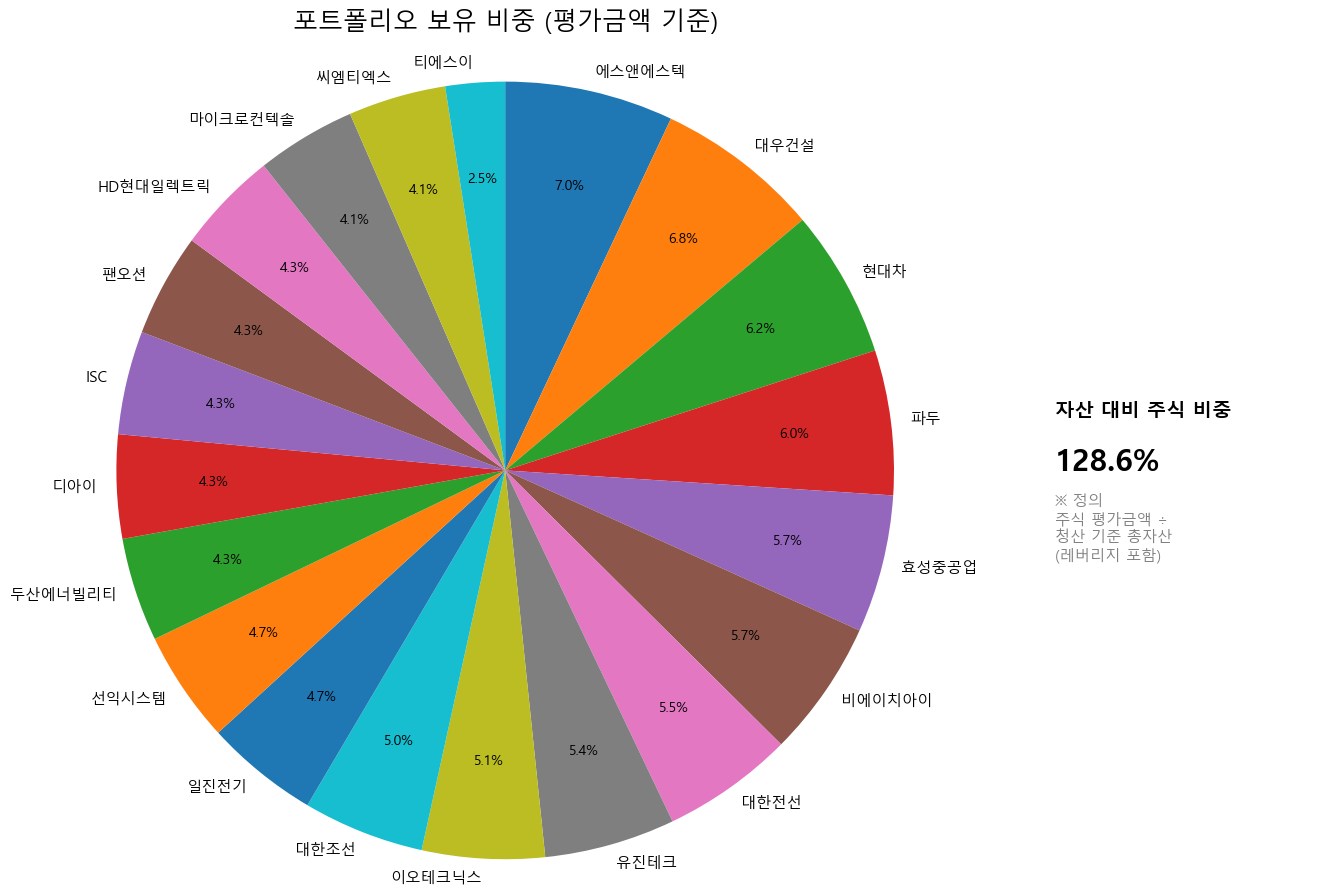

In [23]:
# 파이 차트 그리기
fig = plt.figure(figsize=(14, 9))
ax_pie = fig.add_axes([0.02, 0.05, 0.70, 0.90])
ax_text = fig.add_axes([0.70, 0.30, 0.25, 0.40])

wedges, texts, autotexts = ax_pie.pie(
    df_plot["market_value"],
    labels=df_plot["display_name"],
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    counterclock=False,
    radius=1.2,
    labeldistance=1.05,
    pctdistance=0.75
)

ax_pie.set_title("포트폴리오 보유 비중 (평가금액 기준)", fontsize=18, pad=26)

for t in texts:
    t.set_fontsize(11)
for t in autotexts:
    t.set_fontsize(10)

# 우측 텍스트
ax_text.axis("off")
ax_text.text(0.25, 0.65, "자산 대비 주식 비중", fontsize=14, fontweight="bold")
ax_text.text(0.25, 0.50, f"{stock_exposure_pct:.1f}%", fontsize=22, fontweight="bold")
ax_text.text(0.25, 0.25, "※ 정의\n주식 평가금액 ÷\n청산 기준 총자산\n(레버리지 포함)", fontsize=11, color="gray")

plt.show()

---
## 3. 보유 종목별 수익률 / 홀딩기간 (막대 차트)

In [24]:
# portfolio_snapshot 기준 종목별 종합 수익률 (신용/현금 통합, lot 구분 없이)
sql_holdings = """
WITH stock_summary AS (
    -- 종목코드별 합산 (신용/현금 통합)
    SELECT
        stock_code,
        MAX(stock_name) AS stock_name,
        SUM(total_quantity) AS total_quantity,
        SUM(total_cost) AS total_cost,
        MAX(current_price) AS current_price,
        SUM(market_value) AS market_value,
        SUM(unrealized_pnl) AS unrealized_pnl,
        SUM(portfolio_weight_pct) AS portfolio_weight_pct
    FROM portfolio_snapshot
    WHERE snapshot_date = :snapshot_date
    GROUP BY stock_code
),
prev_holdings AS (
    SELECT DISTINCT REGEXP_REPLACE(stk_cd, '[^0-9]', '') AS stock_code
    FROM holdings
    WHERE snapshot_date = (
        SELECT MAX(snapshot_date) FROM holdings WHERE snapshot_date < :snapshot_date
    )
),
holdings_first_date AS (
    SELECT
        REGEXP_REPLACE(stk_cd, '[^0-9]', '') AS stock_code,
        MIN(snapshot_date) AS first_held_date
    FROM holdings
    GROUP BY REGEXP_REPLACE(stk_cd, '[^0-9]', '')
),
today_net_buy AS (
    SELECT
        stk_cd AS stock_code
    FROM account_trade_history
    WHERE trade_date = :snapshot_date
    GROUP BY stk_cd
    HAVING SUM(CASE WHEN io_tp_nm LIKE '%매수%' THEN cntr_qty ELSE 0 END)
         > SUM(CASE WHEN io_tp_nm LIKE '%매도%' OR io_tp_nm LIKE '%상환%' THEN cntr_qty ELSE 0 END)
)
SELECT
    ss.stock_code AS 종목코드,
    ss.stock_name AS 종목명,
    ss.total_quantity AS 수량,
    ss.total_cost / ss.total_quantity AS 매수평균가,
    ss.current_price AS 현재가,
    ss.market_value AS 평가금액,
    ss.unrealized_pnl / ss.total_cost * 100 AS 수익률,
    ss.portfolio_weight_pct AS 비중,
    COALESCE(
        MAX(dl.holding_days),
        DATEDIFF(:snapshot_date, MIN(dl.trade_date)),
        DATEDIFF(:snapshot_date, MIN(hf.first_held_date))
    ) AS 홀딩기간,
    MAX(CASE WHEN tnb.stock_code IS NOT NULL THEN 1 ELSE 0 END) AS has_today_buy,
    MAX(CASE WHEN dl.trade_date < :snapshot_date OR ph.stock_code IS NOT NULL THEN 1 ELSE 0 END) AS has_old_lot
FROM stock_summary ss
LEFT JOIN daily_lots dl ON ss.stock_code = dl.stock_code AND dl.is_closed = FALSE
LEFT JOIN prev_holdings ph ON ss.stock_code = ph.stock_code
LEFT JOIN holdings_first_date hf ON ss.stock_code = hf.stock_code
LEFT JOIN today_net_buy tnb ON ss.stock_code = tnb.stock_code
GROUP BY ss.stock_code, ss.stock_name, ss.total_quantity, ss.total_cost,
         ss.current_price, ss.market_value, ss.unrealized_pnl, ss.portfolio_weight_pct
ORDER BY 수익률 DESC
"""

df_holdings = pd.read_sql(text(sql_holdings), engine, params={"snapshot_date": LATEST_TRADING_DATE})

# 종목명에서 * 제거
df_holdings["clean_name"] = df_holdings["종목명"].str.replace("*", "", regex=False).str.strip()

# 라벨 결정: 신규매수 / 추가매수 / 없음
def get_label(row):
    name = row['clean_name']
    if row['has_today_buy'] and row['has_old_lot']:
        return f"{name}\n(추가매수)"
    elif row['has_today_buy'] and not row['has_old_lot']:
        return f"{name}\n(신규매수)"
    else:
        return name

df_holdings["표시명"] = df_holdings.apply(get_label, axis=1)

new_buy_count = ((df_holdings['has_today_buy'] == 1) & (df_holdings['has_old_lot'] == 0)).sum()
add_buy_count = ((df_holdings['has_today_buy'] == 1) & (df_holdings['has_old_lot'] == 1)).sum()
print(f"보유 종목: {len(df_holdings)}개 (신규매수: {new_buy_count}개, 추가매수: {add_buy_count}개)")
df_holdings[['종목명', '수익률', '비중', '홀딩기간', 'has_today_buy', 'has_old_lot']].head(10)

보유 종목: 20개 (신규매수: 0개, 추가매수: 0개)


,종목명,수익률,비중,홀딩기간,has_today_buy,has_old_lot
0,*대우건설,74.827586,8.8088,18,0,1
1,*일진전기,25.000000,6.0706,18,0,1
2,비에이치아이,23.150547,7.3176,37,0,1
3,*ISC,19.012346,5.5326,21,0,1
4,*효성중공업,18.439270,7.3645,44,0,1
5,에스앤에스텍,18.414612,9.0119,37,0,1
6,현대차,17.672163,7.9123,2,0,1
7,*유진테크,17.543860,6.9915,8,0,1
8,파두,16.962525,7.7349,7,0,1
9,*티에스이,15.721497,3.1775,37,0,1


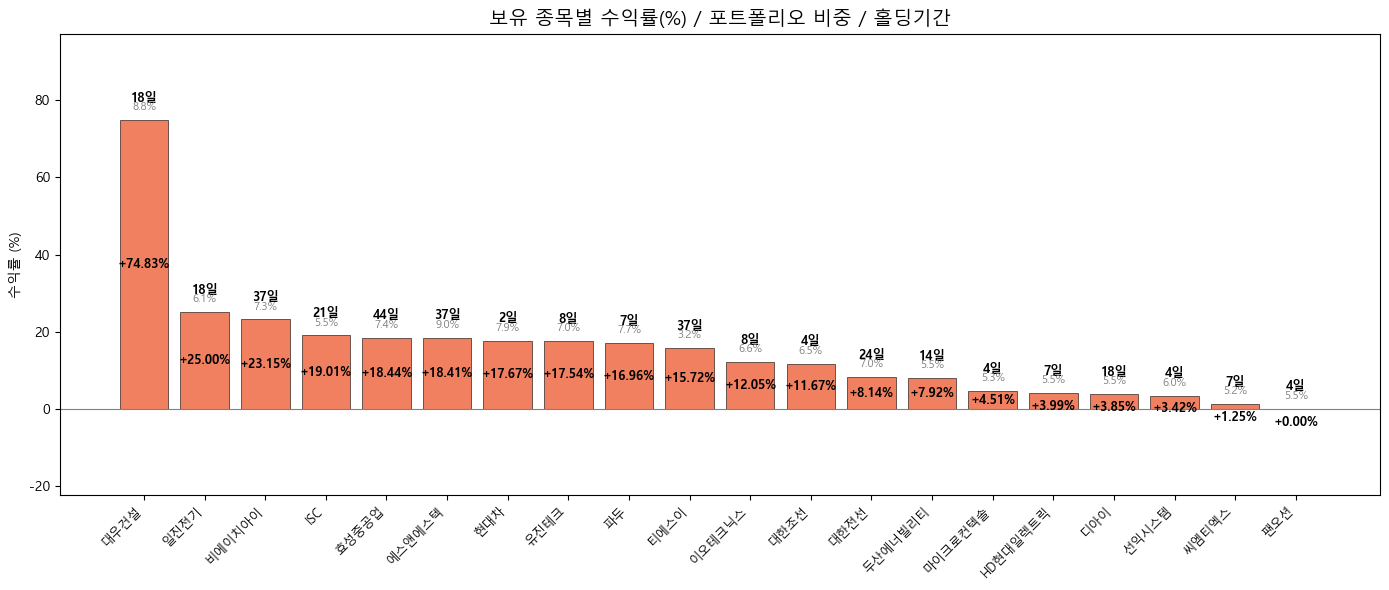

In [25]:
# 막대 차트 설정 (수익률 + 비중 + 홀딩기간 표시)
MAX_BARS = len(df_holdings)  # 전체 표시 (필요시 숫자로 변경: 예) MAX_BARS = 35)

plot_df = df_holdings.head(MAX_BARS).copy()

x = np.arange(len(plot_df))
y = plot_df["수익률"].astype(float).values
weight = plot_df["비중"].astype(float).values
holding = plot_df["홀딩기간"].fillna(0).astype(int).values
names = plot_df["표시명"].astype(str).values  # 신규매수 표시 포함

plt.figure(figsize=(max(14, len(plot_df) * 0.5), 6))

colors = ["#f08060" if v >= 0 else "#4f7bd9" for v in y]
bars = plt.bar(x, y, color=colors, edgecolor="black", linewidth=0.4)

plt.axhline(0, color="gray", linewidth=0.8)
plt.xticks(x, names, rotation=45, ha="right", fontsize=9)
plt.ylabel("수익률 (%)")
plt.title("보유 종목별 수익률(%) / 포트폴리오 비중 / 홀딩기간", fontsize=14)

ymax = max(y.max(), 0)
ymin = min(y.min(), 0)
pad = max((ymax - ymin) * 0.30, 5)
plt.ylim(ymin - pad, ymax + pad)

INSIDE_THRESHOLD = 4.0
OFFSET = 1.8

for bar, ret, w, days in zip(bars, y, weight, holding):
    cx = bar.get_x() + bar.get_width() / 2
    
    # 홀딩기간 (가장 바깥, 더 큰 글씨) - 0일도 표시
    holding_y = ret + (OFFSET * 2.2 if ret >= 0 else -OFFSET * 2.2)
    plt.text(cx, holding_y, f"{days}일", ha="center", 
             va="bottom" if ret >= 0 else "top", fontsize=9, color="black", fontweight="bold")
    
    # 비중 (바깥)
    weight_y = ret + (OFFSET if ret >= 0 else -OFFSET)
    plt.text(cx, weight_y, f"{w:.1f}%", ha="center", 
             va="bottom" if ret >= 0 else "top", fontsize=8, color="gray")
    
    # 수익률 (안쪽)
    if abs(ret) >= INSIDE_THRESHOLD:
        ret_y = ret * 0.5
        va = "center"
    else:
        ret_y = ret - OFFSET if ret >= 0 else ret + OFFSET
        va = "top" if ret >= 0 else "bottom"
    
    plt.text(cx, ret_y, f"{ret:+.2f}%", ha="center", va=va, 
             fontsize=9, color="black", fontweight="bold")

plt.tight_layout()
plt.show()

---
## 4. 포트폴리오 vs KOSPI/KOSDAQ 수익률 비교

In [26]:
# 기간 설정
START_DATE = date(2026, 2, 1)
END_DATE = LATEST_TRADING_DATE

sql_portfolio = """
SELECT
    snapshot_date,
    day_stk_asst AS total_asset,
    COALESCE(ina_amt, 0) AS deposit,
    COALESCE(outa, 0) AS withdrawal
FROM daily_portfolio_snapshot
WHERE snapshot_date BETWEEN :start_date AND :end_date
ORDER BY snapshot_date
"""

sql_index = """
SELECT
    index_date,
    kospi_close,
    kosdaq_close
FROM market_index
WHERE index_date BETWEEN :start_date AND :end_date
ORDER BY index_date
"""

df_portfolio = pd.read_sql(text(sql_portfolio), engine, params={"start_date": START_DATE, "end_date": END_DATE})
df_index = pd.read_sql(text(sql_index), engine, params={"start_date": START_DATE, "end_date": END_DATE})

print(f"Portfolio data: {len(df_portfolio)} days")
print(f"Index data: {len(df_index)} days")

Portfolio data: 17 days
Index data: 17 days


In [27]:
# 시간가중수익률 (TWR) 계산 - 일별 누적 포함
def calculate_twr_daily(df):
    """Time-Weighted Return 계산 (일별 누적 수익률 반환)"""
    if len(df) < 2:
        return pd.DataFrame(), 0.0
    
    df = df.sort_values('snapshot_date').reset_index(drop=True)
    cumulative_returns = [1.0]  # 시작점
    
    for i in range(1, len(df)):
        prev_asset = df.loc[i-1, 'total_asset']
        curr_asset = df.loc[i, 'total_asset']
        cash_flow = df.loc[i, 'deposit'] - df.loc[i, 'withdrawal']
        
        # 현금흐름 조정: 기초자산에 현금흐름 더함
        adjusted_prev = prev_asset + cash_flow
        
        if adjusted_prev > 0:
            period_return = curr_asset / adjusted_prev
        else:
            period_return = 1.0
        
        cumulative_returns.append(cumulative_returns[-1] * period_return)
    
    df_result = df[['snapshot_date']].copy()
    df_result['twr_cumulative'] = cumulative_returns
    df_result['twr_pct'] = (df_result['twr_cumulative'] - 1) * 100
    
    final_twr = (cumulative_returns[-1] - 1) * 100
    return df_result, final_twr

# 금액가중수익률 (MWR) 계산 - 일별 근사
def calculate_mwr_daily(df):
    """Money-Weighted Return 일별 근사 계산"""
    if len(df) < 2:
        return pd.DataFrame(), 0.0
    
    df = df.sort_values('snapshot_date').reset_index(drop=True)
    
    initial_asset = df.loc[0, 'total_asset']
    results = []
    
    cumulative_deposit = 0
    cumulative_withdrawal = 0
    
    for i in range(len(df)):
        cumulative_deposit += df.loc[i, 'deposit']
        cumulative_withdrawal += df.loc[i, 'withdrawal']
        
        current_asset = df.loc[i, 'total_asset']
        net_cash_flow = cumulative_deposit - cumulative_withdrawal
        
        # MWR 근사: (현재자산 - 초기자산 - 순입금) / (초기자산 + 순입금/2)
        gain = current_asset - initial_asset - net_cash_flow
        avg_capital = initial_asset + net_cash_flow / 2
        
        if avg_capital > 0:
            mwr_pct = (gain / avg_capital) * 100
        else:
            mwr_pct = 0
        
        results.append({
            'snapshot_date': df.loc[i, 'snapshot_date'],
            'mwr_pct': mwr_pct
        })
    
    df_result = pd.DataFrame(results)
    final_mwr = results[-1]['mwr_pct'] if results else 0.0
    return df_result, final_mwr

# 지수 수익률 계산 - 일별
def calculate_index_return_daily(df, column):
    """지수 일별 수익률 계산"""
    if len(df) < 1:
        return pd.DataFrame(), 0.0
    
    df = df.sort_values('index_date').reset_index(drop=True)
    start_val = df.loc[0, column]
    
    df_result = df[['index_date']].copy()
    df_result[f'{column}_pct'] = (df[column] / start_val - 1) * 100
    
    final_return = df_result[f'{column}_pct'].iloc[-1]
    return df_result, final_return

In [28]:
# 수익률 계산
df_twr, twr = calculate_twr_daily(df_portfolio)
df_mwr, mwr = calculate_mwr_daily(df_portfolio)
df_kospi, kospi_return = calculate_index_return_daily(df_index, 'kospi_close')
df_kosdaq, kosdaq_return = calculate_index_return_daily(df_index, 'kosdaq_close')

print(f"\n=== 수익률 비교 ({START_DATE} ~ {END_DATE}) ===")
print(f"")
print(f"내 포트폴리오 (TWR): {twr:+.2f}%")
print(f"내 포트폴리오 (MWR): {mwr:+.2f}%")
print(f"KOSPI:              {kospi_return:+.2f}%")
print(f"KOSDAQ:             {kosdaq_return:+.2f}%")
print(f"")
print(f"vs KOSPI 초과수익:  {twr - kospi_return:+.2f}%p")
print(f"vs KOSDAQ 초과수익: {twr - kosdaq_return:+.2f}%p")


=== 수익률 비교 (2026-02-01 ~ 2026-02-27) ===

내 포트폴리오 (TWR): +15.33%
내 포트폴리오 (MWR): +15.33%
KOSPI:              +26.15%
KOSDAQ:             +8.60%

vs KOSPI 초과수익:  -10.83%p
vs KOSDAQ 초과수익: +6.73%p


In [ ]:
# 비교 막대 차트
returns = {
    '내 포트폴리오\n(TWR)': twr,
    '내 포트폴리오\n(MWR)': mwr,
    'KOSPI': kospi_return,
    'KOSDAQ': kosdaq_return
}

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(returns))
values = list(returns.values())

# 내 포트폴리오는 파란 계열, 지수는 양/음에 따라 초록/빨강
bar_colors = [
    '#1a73e8',  # TWR - 진한 파랑
    '#4a9af5',  # MWR - 밝은 파랑
    '#2ecc71' if kospi_return >= 0 else '#e74c3c',   # KOSPI
    '#2ecc71' if kosdaq_return >= 0 else '#e74c3c',   # KOSDAQ
]

bars = ax.bar(x, values, color=bar_colors, edgecolor='black', linewidth=0.5, width=0.6)

ax.axhline(0, color='gray', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(returns.keys(), fontsize=12)
ax.set_ylabel('수익률 (%)', fontsize=12)
ax.set_title(f'수익률 비교 ({START_DATE} ~ {END_DATE})', fontsize=14, fontweight='bold')

# 값 표시
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (1 if height >= 0 else -2),
            f'{val:+.2f}%', ha='center', va='bottom' if height >= 0 else 'top',
            fontsize=14, fontweight='bold')

# y축 범위 조정
ymax = max(max(values), 0) + 5
ymin = min(min(values), 0) - 5
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

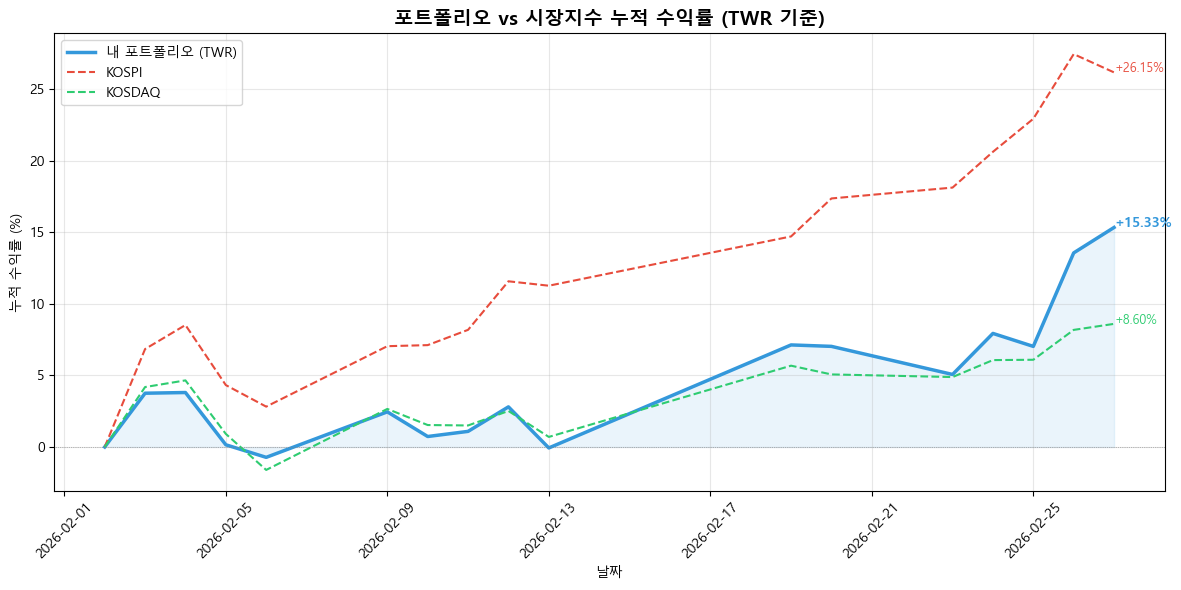

In [30]:
# 일별 누적 수익률 추이 (TWR 기준 - 입출금 영향 제거)

# 데이터 병합
df_merged = pd.merge(
    df_twr[['snapshot_date', 'twr_pct']],
    df_kospi[['index_date', 'kospi_close_pct']],
    left_on='snapshot_date',
    right_on='index_date',
    how='inner'
)

df_merged = pd.merge(
    df_merged,
    df_kosdaq[['index_date', 'kosdaq_close_pct']],
    on='index_date',
    how='inner'
).sort_values('snapshot_date')

if len(df_merged) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(df_merged['snapshot_date'], df_merged['twr_pct'], 
            label='내 포트폴리오 (TWR)', linewidth=2.5, color='#3498db')
    ax.plot(df_merged['snapshot_date'], df_merged['kospi_close_pct'], 
            label='KOSPI', linewidth=1.5, color='#e74c3c', linestyle='--')
    ax.plot(df_merged['snapshot_date'], df_merged['kosdaq_close_pct'], 
            label='KOSDAQ', linewidth=1.5, color='#2ecc71', linestyle='--')
    
    ax.axhline(0, color='gray', linewidth=0.5, linestyle=':')
    ax.fill_between(df_merged['snapshot_date'], 0, df_merged['twr_pct'], 
                    alpha=0.1, color='#3498db')
    
    ax.set_xlabel('날짜')
    ax.set_ylabel('누적 수익률 (%)')
    ax.set_title('포트폴리오 vs 시장지수 누적 수익률 (TWR 기준)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # 최종 수익률 표시
    last_date = df_merged['snapshot_date'].iloc[-1]
    ax.annotate(f'{twr:+.2f}%', xy=(last_date, twr), fontsize=10, fontweight='bold', color='#3498db')
    ax.annotate(f'{kospi_return:+.2f}%', xy=(last_date, kospi_return), fontsize=9, color='#e74c3c')
    ax.annotate(f'{kosdaq_return:+.2f}%', xy=(last_date, kosdaq_return), fontsize=9, color='#2ecc71')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("데이터가 부족합니다.")

---
## 5. 요약 테이블

In [31]:
# 전체 요약
summary_data = {
    '지표': [
        f'기간',
        '내 포트폴리오 (TWR)',
        '내 포트폴리오 (MWR)',
        'KOSPI',
        'KOSDAQ',
        'vs KOSPI 초과수익',
        'vs KOSDAQ 초과수익'
    ],
    '값': [
        f'{START_DATE} ~ {END_DATE} ({(END_DATE - START_DATE).days}일)',
        f'{twr:+.2f}%',
        f'{mwr:+.2f}%',
        f'{kospi_return:+.2f}%',
        f'{kosdaq_return:+.2f}%',
        f'{twr - kospi_return:+.2f}%p',
        f'{twr - kosdaq_return:+.2f}%p'
    ]
}

df_summary = pd.DataFrame(summary_data)
df_summary.style.set_properties(**{'text-align': 'right'}).set_properties(subset=['지표'], **{'text-align': 'left', 'font-weight': 'bold'})

,지표,값
0,기간,2026-02-01 ~ 2026-02-27 (26일)
1,내 포트폴리오 (TWR),+15.33%
2,내 포트폴리오 (MWR),+15.33%
3,KOSPI,+26.15%
4,KOSDAQ,+8.60%
5,vs KOSPI 초과수익,-10.83%p
6,vs KOSDAQ 초과수익,+6.73%p


In [32]:
# DB 연결 종료
engine.dispose()
print("Done!")

Done!
